# Pitch Prediction

The goal of this project is to see if I can build a model to predict what pitch a pitcher is going to throw next. As a start, I used the pitchRx package in R to create a SQLite database with all of the PITCHF/x data needed. The first step in the project is to query that database for the necessary data. 

## Querying the DB

Here I'm going to take a look at the tables in the database, determine what data I want, and write a query to get that data.

In [1]:
#Import libraries

import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
%matplotlib inline

In [2]:
#Create connection to sqlite database

db_path = "2017_pitchfx.sqlite3"
con = sqlite3.connect(db_path)

In [3]:
#View tables in the database

cur = con.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
print(tables)

[('atbat',), ('action',), ('pitch',), ('po',), ('runner',)]


In [4]:
#Print columns in tables

def print_col_names(table_list):
    for table in table_list:
        cur.execute("SELECT * FROM %s;" %table)
        names = list(map(lambda x: x[0], cur.description))
        print('Columns in %s: \n' %table, names, '\n')
        
print_col_names(tables)

Columns in atbat: 
 ['pitcher', 'batter', 'num', 'b', 's', 'o', 'start_tfs', 'start_tfs_zulu', 'stand', 'b_height', 'p_throws', 'atbat_des', 'atbat_des_es', 'event', 'score', 'home_team_runs', 'away_team_runs', 'url', 'inning_side', 'inning', 'next_', 'event2', 'event3', 'batter_name', 'pitcher_name', 'event4', 'gameday_link', 'date', 'event_num', 'event_es', 'play_guid', 'event2_es', 'end_tfs_zulu', 'event3_es'] 

Columns in action: 
 ['b', 's', 'o', 'des', 'des_es', 'event', 'tfs', 'tfs_zulu', 'player', 'pitch', 'url', 'inning_side', 'inning', 'next_', 'num', 'score', 'home_team_runs', 'away_team_runs', 'event2', 'gameday_link', 'event_es', 'event_num', 'play_guid', 'event2_es'] 

Columns in pitch: 
 ['des', 'des_es', 'id', 'type', 'tfs', 'tfs_zulu', 'x', 'y', 'sv_id', 'start_speed', 'end_speed', 'sz_top', 'sz_bot', 'pfx_x', 'pfx_z', 'px', 'pz', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'break_y', 'break_angle', 'break_length', 'pitch_type', 'type_confidence', 'zone', 

Here is the list of columns I'm interested in for exploratory analysis and building my model:

From the atbat table:

|Column|Description|
|:-----|:-----------|
|num|Number of the at bat in the game|
|stand|Batter handedness|
|pitcher_name|Pitcher name|


From the pitch table:

|Column|Description|
|:-----|:-----------|
|px|the left/right distance, in feet, of the pitch from the middle of the plate as it crossed home plate. The PITCHf/x coordinate system is oriented to the catcher’s/umpire’s perspective, with distances to the right being positive and to the left being negative. ([source](https://fastballs.wordpress.com/2007/08/02/glossary-of-the-gameday-pitch-fields/))|
|pz|the height of the pitch in feet as it crossed the front of home plate. ([source](https://fastballs.wordpress.com/2007/08/02/glossary-of-the-gameday-pitch-fields/))|
|pitch_type|MLBAM's prediction for the type of pitch thrown|
|on_1b|ID of the runner on first base|
|on_2b|ID of the runner on second base|
|on_3b|ID of the runner on third base|
|count|The current count in the at bat|

I'm also going to be grabbing a few columns that will help me with feature engineering down the line. 

### Performing the Query

In [5]:
def get_pitcher_data(pitcher_name):
    df = pd.read_sql_query("SELECT ab.pitcher_name, ab.stand, p.count, \
                           p.px, p.pz, p.pitch_type, p.on_1b, p.on_2b, p.on_3b, p.num, p.gameday_link \
                           FROM pitch AS p \
                           LEFT OUTER JOIN atbat AS ab \
                           ON ab.gameday_link = p.gameday_link \
                           AND ab.num = p.num \
                           WHERE ab.pitcher_name = '%s';" % pitcher_name, con)
    return df

In [6]:
kershaw = get_pitcher_data('Clayton Kershaw')

In [7]:
kershaw.head(10)

,pitcher_name,stand,count,px,pz,pitch_type,on_1b,on_2b,on_3b,num,gameday_link
0,Clayton Kershaw,R,0-0,-0.903222,2.579589,FF,NaN,NaN,453568.0,22.0,gid_2017_04_08_lanmlb_colmlb_1
1,Clayton Kershaw,R,0-0,-0.896615,2.162837,FF,467827.0,448602.0,NaN,32.0,gid_2017_04_08_lanmlb_colmlb_1
2,Clayton Kershaw,R,1-1,-0.756494,2.526617,FF,467827.0,448602.0,NaN,32.0,gid_2017_04_08_lanmlb_colmlb_1
3,Clayton Kershaw,R,0-1,0.325779,0.686945,SL,467827.0,448602.0,NaN,32.0,gid_2017_04_08_lanmlb_colmlb_1
4,Clayton Kershaw,R,0-0,-0.154359,1.404650,SL,NaN,NaN,NaN,27.0,gid_2017_04_14_arimlb_lanmlb_1
5,Clayton Kershaw,R,0-1,0.309749,2.721547,FF,NaN,NaN,NaN,27.0,gid_2017_04_14_arimlb_lanmlb_1
6,Clayton Kershaw,R,0-0,-0.466681,3.273685,FF,NaN,NaN,NaN,13.0,gid_2017_04_08_lanmlb_colmlb_1
7,Clayton Kershaw,R,0-1,0.262394,1.670713,CU,NaN,NaN,NaN,13.0,gid_2017_04_08_lanmlb_colmlb_1
8,Clayton Kershaw,R,0-2,1.009219,2.911815,FF,NaN,NaN,NaN,13.0,gid_2017_04_08_lanmlb_colmlb_1
9,Clayton Kershaw,R,0-0,-0.221781,1.714192,FF,NaN,NaN,NaN,58.0,gid_2017_04_03_sdnmlb_lanmlb_1


In [32]:
#Close db connection
con.close()

## Data Cleaning and Feature Engineering

I can already see from my quick look at the data above that I'm going to want to clean up some columns. I also want to creare a few columns that I think might be useful for my analysis. One of the things I noticed right away is that the on-base columns are not booleans as I thought they might be, but actually contain player IDs. For my purposes, I'm going to switch these to a boolean response (1 for a man on, 0 for an empty base). 

In [33]:
def convert_on_base(df):
    #Fill NaN's with 0s
    df['on_1b'].fillna(0, inplace = True)
    df['on_2b'].fillna(0, inplace = True)
    df['on_3b'].fillna(0, inplace = True)
    #Now convert non-0 values to 1, just to indicate there is a man on. 
    df['on_1b'][df['on_1b'] > 0] = 1
    df['on_2b'][df['on_2b'] > 0] = 1
    df['on_3b'][df['on_3b'] > 0] = 1
    return df

kershaw = convert_on_base(kershaw)

#Check info
kershaw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2436 entries, 0 to 2520
Data columns (total 15 columns):
pitcher_name    2436 non-null object
stand           2436 non-null object
count           2436 non-null object
px              2436 non-null float64
pz              2436 non-null float64
pitch_type      2436 non-null object
on_1b           2436 non-null float64
on_2b           2436 non-null float64
on_3b           2436 non-null float64
num             2436 non-null float64
gameday_link    2436 non-null object
tto             2436 non-null float64
prev_pitch      2436 non-null object
balls           2436 non-null object
strikes         2436 non-null object
dtypes: float64(7), object(8)
memory usage: 384.5+ KB


There is still some missing PitchF/x data, but I'm going to leave it here for now because removing it would affect the next two features.

### Feature Engineering: Times through order

An input I want to capture is the number of times the pitcher has gone through the batting order. 'The Book' by Tango et al. shows that batters gain an advantage on a starting pitcher as the game goes on. This is likely partly due to fatigue of the pitcher, but it could also be that as they face the pitcher more, they learn more about his tendencies. Thus, a pitcher has incentive to change his pitch selection or sequencing each additional time he faces a batter.  

In [34]:
#Add a 'tto' columns to dataframe

def compute_tto(df):
    df['tto'] = np.zeros(len(df))
    active_game = df['gameday_link'].iloc[0]
    active_ab = df['num'].iloc[0]
    ab = 1
    tto = 1
    for i in range(len(df)):
        current_game = df['gameday_link'].iloc[i]
        current_ab = df['num'].iloc[i]
        if (current_game != active_game):
            active_game = current_game
            ab = 1
            tto = 1
            df['tto'].iloc[i] = tto
        elif (current_ab != active_ab):
            active_ab = current_ab
            ab += 1
            if (ab <= 9):
                df['tto'].iloc[i] = tto
            elif (ab <= 18):
                tto = 2
                df['tto'].iloc[i] = tto
            else: 
                tto = 3
                df['tto'].iloc[i] = tto
        else:
            df['tto'].iloc[i] = tto
    return df

kershaw = compute_tto(kershaw)
kershaw.head()

,pitcher_name,stand,count,px,pz,pitch_type,on_1b,on_2b,on_3b,num,gameday_link,tto,prev_pitch,balls,strikes
0,Clayton Kershaw,R,0-0,-0.903222,2.579589,FF,0.0,0.0,1.0,22.0,gid_2017_04_08_lanmlb_colmlb_1,1.0,First Pitch,0,0
1,Clayton Kershaw,R,0-0,-0.896615,2.162837,FF,1.0,1.0,0.0,32.0,gid_2017_04_08_lanmlb_colmlb_1,1.0,First Pitch,0,0
2,Clayton Kershaw,R,1-1,-0.756494,2.526617,FF,1.0,1.0,0.0,32.0,gid_2017_04_08_lanmlb_colmlb_1,1.0,FF,1,1
3,Clayton Kershaw,R,0-1,0.325779,0.686945,SL,1.0,1.0,0.0,32.0,gid_2017_04_08_lanmlb_colmlb_1,1.0,FF,0,1
4,Clayton Kershaw,R,0-0,-0.154359,1.404650,SL,0.0,0.0,0.0,27.0,gid_2017_04_14_arimlb_lanmlb_1,1.0,First Pitch,0,0


### Feature Engineering: Previous Pitch Thrown

I'd also like to capture the previous pitch thrown, in case the pitcher has any tendencies to now throw a pitch multiple times in a row. Recall, however, that I previously dropped a few rows of data with unknown pitch information.
Using the method below, not having this data will result in misattributed previous pitches. I'll recreate the dataframe with the missing data, create the previous pitch column, then filter out the missing data. 

In [35]:
def prev_pitches(df):
    df['prev_pitch'] = np.zeros(len(df))
    for i in range(len(df)):
        if df['count'].iloc[i] == '0-0':
            df['prev_pitch'].iloc[i] = 'First Pitch'
        else:
            df['prev_pitch'].iloc[i] = df['pitch_type'].iloc[i-1]
    return df

kershaw = prev_pitches(kershaw)

### Feature Engineering: Balls and Strikes

Lastly, I want to use the count column to get individual balls and strikes columns. This is so that I can capture the effect on pitch selection in 3-ball and 2-strike situations, regardless of the rest of the count.

In [36]:
#Create separate balls and strikes columns

def split_count(df):
    df['balls'] = df['count'].apply(lambda x: x.split('-')[0])
    df['strikes'] = df['count'].apply(lambda x: x.split('-')[1])
    return df

kershaw = split_count(kershaw)
kershaw.head()

,pitcher_name,stand,count,px,pz,pitch_type,on_1b,on_2b,on_3b,num,gameday_link,tto,prev_pitch,balls,strikes
0,Clayton Kershaw,R,0-0,-0.903222,2.579589,FF,0.0,0.0,1.0,22.0,gid_2017_04_08_lanmlb_colmlb_1,1.0,First Pitch,0,0
1,Clayton Kershaw,R,0-0,-0.896615,2.162837,FF,1.0,1.0,0.0,32.0,gid_2017_04_08_lanmlb_colmlb_1,1.0,First Pitch,0,0
2,Clayton Kershaw,R,1-1,-0.756494,2.526617,FF,1.0,1.0,0.0,32.0,gid_2017_04_08_lanmlb_colmlb_1,1.0,FF,1,1
3,Clayton Kershaw,R,0-1,0.325779,0.686945,SL,1.0,1.0,0.0,32.0,gid_2017_04_08_lanmlb_colmlb_1,1.0,FF,0,1
4,Clayton Kershaw,R,0-0,-0.154359,1.404650,SL,0.0,0.0,0.0,27.0,gid_2017_04_14_arimlb_lanmlb_1,1.0,First Pitch,0,0


Finally, I need to drop the rows with NAs

In [37]:
def drop_nas(df):
    df = df.dropna()
    return df

kershaw = drop_nas(kershaw)

## Exploratory Data Analysis

Let's do some exploratory analysis to see what our best predictors might be

In [38]:
#Define some helper functions

def plot_pitch_dist(df):
    sns.countplot(df['pitch_type'])
    
def pitch_splits(df, split_by = None):
    '''
    Creates a pitch type proportion table based on given split_arg.
    Split args can be:
    - 'stand': batter handedness
    - 'count': count in at bat
    - 'balls': number of balls
    - 'strikes': number of strikes
    - 'on_1b': Man on 1st or not
    - 'on_2b': Man on 2nd or not
    - 'on_3b': Man on 3rd or not
    - 'tto': Times through the batting order
    '''
    if (split_by is not None):
        splits = pd.crosstab(index = df['pitch_type'], columns = df[split_by], normalize = 'columns')
    else:
        splits = pd.DataFrame(df['pitch_type'].value_counts()/sum(df['pitch_type'].value_counts()))
    return splits
    
def plot_pitch_loc(df, split_by = None):
    '''
    Creates plots for of pitch type and location based on given split_arg. 
    Split args can be:
    - 'stand': batter handedness
    - 'count': count in at bat
    - 'balls': number of balls
    - 'strikes': number of strikes
    - 'on_1b': Man on 1st or not
    - 'on_2b': Man on 2nd or not
    - 'on_3b': Man on 3rd or not
    - 'tto': Times through the batting order
    '''
    sns.lmplot(x = 'px', y = 'pz', data = df, fit_reg = False, hue = 'pitch_type', 
               scatter_kws = {'alpha':0.7}, col = split_by, col_wrap = 2)
    

First let's take a look at kershaw's overall pitch counts

    pitch_type
FF    0.454844
SL    0.354269
CU    0.169130
FT    0.011905
CH    0.009852


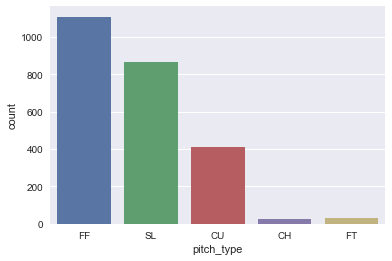

In [39]:
plot_pitch_dist(kershaw)
print(pitch_splits(kershaw))

We see that Kershaw threw 5 different pitches in 2017. Per [Fangraphs](https://www.fangraphs.com/library/pitch-type-abbreviations-classifications/), here are the pitches the PitchF/x abbreviations correspond to:

- FF: Four-seam fastball
- SL: Slider
- FT: Two-seam fastball
- CH: Changeup
- CU: Curveball

He almost never threw his changeup or two-seam fastball, with both coming in around 1% usage. For that reason I'm rarely going to reference them when looking at splits data, since a small number of pitches will drastically change their perceived likelihood of being thrown. Let's see how his pitch selection breaks down by batter handedness. 

stand              L         R
pitch_type                    
CH          0.000000  0.012384
CU          0.138554  0.176987
FF          0.538153  0.433437
FT          0.036145  0.005676
SL          0.287149  0.371517


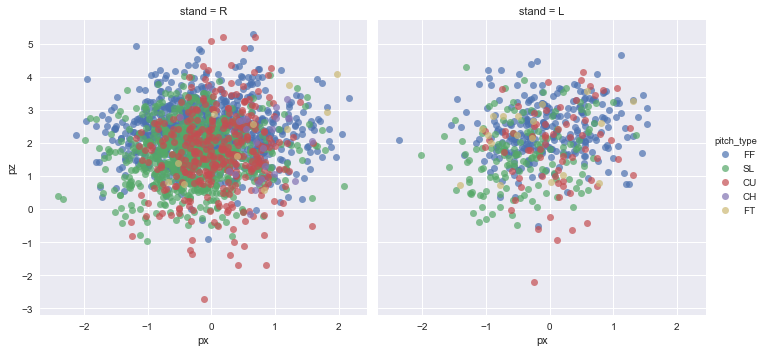

In [40]:
plot_pitch_loc(kershaw, 'stand')
print(pitch_splits(kershaw, 'stand'))

The sample size against left-handed batters is (predictably) much smaller than the right handed matchup. With that caveat, the biggest changes in his pitch selection appear to be in his four-seamer and slider. He was almost 10% more likley to throw a slider against a righty, and 10% less likely to throw a four-seamer. There's also a slight uptick in his curveball usage against righties. 

Now let's look at time through the batting order. (For the remainder of the analysis I'm only going to look at the table to save space)

In [41]:
print(pitch_splits(kershaw, 'tto'))

tto              1.0       2.0       3.0
pitch_type                              
CH          0.010261  0.000000  0.000000
CU          0.171013  0.118421  0.142857
FF          0.453185  0.500000  0.476190
FT          0.012398  0.000000  0.000000
SL          0.353142  0.381579  0.380952


The table actually shows a pretty distinct pattern. Kershaw's likelihood of throwing a four-seamer dropped significantly each time through the order, while the likelihood of each of his other pitches increased.

Let's look at balls and strikes now. 

In [42]:
print(pitch_splits(kershaw, 'balls'))

balls              0         1         2         3
pitch_type                                        
CH          0.016584  0.005626  0.000000  0.000000
CU          0.188226  0.182841  0.139785  0.020408
FF          0.494196  0.398031  0.405914  0.530612
FT          0.013267  0.011252  0.013441  0.000000
SL          0.287728  0.402250  0.440860  0.448980


The biggest takeaways here are that he almost never threw his curveball on 3 balls and that his slider usage jumped significantly on counts with non-zero balls. 

In [43]:
print(pitch_splits(kershaw, 'strikes'))

strikes            0         1         2
pitch_type                              
CH          0.001087  0.030223  0.000000
CU          0.047826  0.270696  0.214570
FF          0.611957  0.344284  0.374834
FT          0.005435  0.013141  0.018543
SL          0.333696  0.341656  0.392053


Here we see Kershaw sacrificing his four-seamer for curveballs on counts with 1 or 2 strikes. There's also a slight uptick in slider usage as the number of strikes increases. 

Let's see if there is anything to be found in his previous pitch data. 

In [44]:
print(pitch_splits(kershaw, 'prev_pitch'))

prev_pitch        CH        CU        FF        FT  First Pitch        SL
pitch_type                                                               
CH          0.000000  0.010453  0.018428  0.000000     0.000000  0.009375
CU          0.000000  0.219512  0.176904  0.263158     0.066768  0.243750
FF          0.647059  0.386760  0.406634  0.210526     0.641882  0.356250
FT          0.000000  0.020906  0.012285  0.105263     0.006070  0.010937
SL          0.352941  0.362369  0.385749  0.421053     0.285281  0.379688


There are two main things to note here. The first is his first pitch percentages. He almost never threw his curveball while throwing his four-seamer and slider 64 and 29 percent of the time, respectively. The second is his pitch selection after throwing a slider. His curveball, which he threw ~17% of the time overall, jumps up to 25%, while his four-seamer drops from ~46% to ~37%.  

Let's take a look at the on-base effects:

In [45]:
print(pitch_splits(kershaw, 'on_1b'))
print(pitch_splits(kershaw, 'on_2b'))
print(pitch_splits(kershaw, 'on_3b'))

on_1b            0.0       1.0
pitch_type                    
CH          0.012541  0.001661
CU          0.172846  0.157807
FF          0.464013  0.426910
FT          0.013086  0.008306
SL          0.337514  0.405316
on_2b            0.0       1.0
pitch_type                    
CH          0.011516  0.000000
CU          0.175144  0.133523
FF          0.467850  0.377841
FT          0.011996  0.011364
SL          0.333493  0.477273
on_3b            0.0       1.0
pitch_type                    
CH          0.010471  0.000000
CU          0.171902  0.125000
FF          0.453752  0.472222
FT          0.011344  0.020833
SL          0.352531  0.381944


What I find most interesting here is the increased use of his slider with a man on 1st or 2nd. 

Alright, let's get into the actual model building.

## Pitch Prediciton Model

I'll use a logistic regression model to perform the actual pitch prediction. I'll test both one-vs-rest and multinomial methods to solve for the fact that this is a multi-class classification problem. 

### Preparing the Data

There are a few data preparation steps required before training a model. 

1. Separate the dependent variable (pitch_type)
2. Decide what columns to use for initial model, remove the remainder
3. Encode any categorical variables
4. Split the data into testing and training sets

For my initial model, the predictor variables I'm going to use are:
- Batter handedness: 'stand'
- Men on base: 'on_1b', 'on_2b', 'on_3b'
- Balls: 'balls'
- Strikes: 'strikes'
- Times-through-order: 'tto
- Previous pitch: 'prev_pitch'

In [46]:
#Split off pitch_type
def split_x_y(df):
    y = df['pitch_type']
    x = df.drop(['pitch_type'], axis = 1)
    return x, y

#Drop unwated columns
def drop_cols(df, columns):
    df = df.drop(columns, axis = 1)
    return df

x, y = split_x_y(kershaw)
cols_to_drop = ['pitcher_name','count','px','pz','gameday_link','num']
x = drop_cols(x, cols_to_drop)

All of my predictors are categorical. I'll use pandas 'get_dummies' to one-hot encode them. 

In [47]:
x.head()

,stand,on_1b,on_2b,on_3b,tto,prev_pitch,balls,strikes
0,R,0.0,0.0,1.0,1.0,First Pitch,0,0
1,R,1.0,1.0,0.0,1.0,First Pitch,0,0
2,R,1.0,1.0,0.0,1.0,FF,1,1
3,R,1.0,1.0,0.0,1.0,FF,0,1
4,R,0.0,0.0,0.0,1.0,First Pitch,0,0


In [48]:
x = pd.get_dummies(x, columns = x.columns.tolist())

In [49]:
x.head()

,stand_L,stand_R,on_1b_0.0,on_1b_1.0,on_2b_0.0,on_2b_1.0,on_3b_0.0,on_3b_1.0,tto_1.0,tto_2.0,...,prev_pitch_FT,prev_pitch_First Pitch,prev_pitch_SL,balls_0,balls_1,balls_2,balls_3,strikes_0,strikes_1,strikes_2
0,0,1,1,0,1,0,0,1,1,0,...,0,1,0,1,0,0,0,1,0,0
1,0,1,0,1,0,1,1,0,1,0,...,0,1,0,1,0,0,0,1,0,0
2,0,1,0,1,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0,1,0,1,0,1,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,0,1,1,0,1,0,1,0,1,0,...,0,1,0,1,0,0,0,1,0,0


Finally, I need to split my data into test and training sets. 

In [50]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1, stratify = y)

### Building the Model

My first model will be an L2-regularized logistic regression with cross-validation using the one-vs-rest multi-classification strategy. 

In [51]:
from sklearn.linear_model import LogisticRegressionCV

ovr = LogisticRegressionCV(cv = 5, max_iter = 100000)
ovr_fit = ovr.fit(x_train, y_train)
ovr_fit.score(x_test, y_test)

0.458128078817734

In [52]:
#Compute confusion matrix

pd.crosstab(y_test, ovr_fit.predict(x_test), rownames=['True'], colnames=['Predicted'])

Predicted,FF,SL
True,,
CH,5,1
CU,56,47
FF,205,72
FT,5,2
SL,142,74


Not great, the model is only predicting four-seamers and sliders. Let's see if the multinomial method does any better

In [53]:
mn = LogisticRegressionCV(cv = 5, max_iter = 100000, multi_class = 'multinomial')
mn_fit = mn.fit(x_train, y_train)
mn_fit.score(x_test, y_test)

0.47126436781609193

In [54]:
#Compute confusion matrix

pd.crosstab(y_test, mn_fit.predict(x_test), rownames=['True'], colnames=['Predicted'])

Predicted,CU,FF,SL
True,,,
CH,2,4,0
CU,20,47,36
FF,11,198,68
FT,2,5,0
SL,12,135,69


### Kernel SVM

In [58]:
#RBF Kernel w/ Grid Search
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc_rbf = SVC(kernel = 'rbf')
params = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000, 10000],
         'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000, 10000]}

gscv_svc_rbf = GridSearchCV(svc_rbf, params)
grid = gscv_svc_rbf.fit(x_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.49


In [59]:
pd.crosstab(y_test, grid.predict(x_test), rownames=['True'], colnames=['Predicted'])

Predicted,CU,FF,SL
True,,,
CH,6,0,0
CU,27,50,26
FF,25,191,61
FT,0,7,0
SL,18,134,64


### Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rfc_default = RandomForestClassifier(n_estimators = 100)
rfc_default_fit = rfc_default.fit(x_train, y_train)
rfc_default_fit.score(x_test, y_test)

0.4696223316912972

In [71]:
pd.crosstab(y_test, rfc_default_fit.predict(x_test), rownames=['True'], colnames=['Predicted'])

Predicted,CU,FF,FT,SL
True,,,,
CH,5,1,0,0
CU,32,42,1,28
FF,33,188,0,56
FT,0,6,0,1
SL,29,121,0,66


### Future Improvements
- Use l1-regularized (LASSO) logistic regression to determine best/worst predictors 
- Test more SVM classifiers
- Use GridSearchCV with RandomForest
- Test ensemble of classifier models